In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
MNIST = input_data.read_data_sets("MNIST_DATA/", one_hot=False)

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


### parameters

In [3]:
xn = 784
hn1 = 400
hn2 = 400
zn = 2 # z dim
bn = 100 #batch size

In [4]:
def weight_tensor(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01))
def bias_tensor(shape):
    return tf.Variable(tf.zeros(shape)+0.1)

### encode

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[bn, xn])

In [6]:
w1 = weight_tensor([xn, hn1])
b1 = bias_tensor([hn1])

h1 = tf.nn.relu(tf.matmul(x, w1) + b1)

In [7]:
w2 = weight_tensor([hn1, hn2])
b2 = bias_tensor([hn2])

h2 = tf.nn.relu(tf.matmul(h1,w2) +b2)

In [8]:
zw1 = weight_tensor([hn2, zn])
zb1 = bias_tensor([zn])

zw2 = weight_tensor([hn2, zn])
zb2 = bias_tensor([zn])

z_mean = tf.matmul(h2, zw1) + zb1
z_sig_log_square = tf.matmul(h2, zw2) + zb2

#### batch size = 100 일때 sampling L= 1

In [9]:
eps = tf.random_normal(shape=tf.shape(z_sig_log_square), mean=0, stddev=1)

In [10]:
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp((z_sig_log_square))), eps))

### decode

In [11]:
w3 = weight_tensor([zn, hn2])
b3 = bias_tensor([hn2])

h3 = tf.nn.relu(tf.matmul(z, w3)+ b3)

In [12]:
w4 = weight_tensor([hn2, hn1])
b4 = bias_tensor([hn1])

h4 = tf.nn.relu(tf.matmul(h3, w4)+ b4)

In [13]:
xw1 = weight_tensor([hn1, xn])
xb1 = bias_tensor([xn])

xw2 = weight_tensor([hn1, xn])
xb2 = bias_tensor([xn])

x_hat_mean = tf.sigmoid(tf.matmul(h4, xw1) + xb1)
# x_hat_log_sig_square = tf.sigmoid(tf.matmul(h4, xw2) + xb2)

# x_hat = tf.add(x_hat_mean, tf.sqrt(tf.exp(x_hat_log_sig_square)))
x_hat = x_hat_mean

### loss

## (1) 식
$\log { { p }_{ \theta  }(x)\quad  } =\quad \int { { q }_{ \phi  }(z|x)\log { p_{ \theta  }(x)\quad  } \quad  } \\ \quad \quad \quad \quad \quad \quad \quad \quad =\quad \int { { q }_{ \phi  }(z|x)\log { \frac { { p }_{ \theta  }(z,x) }{ { p }_{ \theta  }(z|x) }  }  } \\ \quad \quad \quad \quad \quad \quad \quad \quad =\quad \int { { q }_{ \phi  }(z|x)\log { \frac { { p }_{ \theta  }(z,x){ q }_{ \phi  }(z|x) }{ { p }_{ \theta  }(z|x){ q }_{ \phi  }(z|x) }  }  } \\ \quad \quad \quad \quad \quad \quad \quad \quad =\quad \int { { q }_{ \phi  }(z|x)\log { \frac { { p }_{ \theta  }(z,x) }{ { q }_{ \phi  }(z|x) }  }  } +\int { { q }_{ \phi  }(z|x)\log { \frac { { q }_{ \phi  }(z|x) }{ { p }_{ \theta  }(z|x) }  }  } \\ \quad \quad \quad \quad \quad \quad \quad \quad =\quad L(\theta ,\phi ;x)+{ D }_{ KL }({ q }_{ \phi  }(z|x)||{ p }_{ \theta  }(z|x))\quad $

## (3)식
$L(\theta ,\phi ;x)\quad =\quad \int { { q }_{ \phi  }(z|x)\log { \frac { { p }_{ \theta  }(z,x) }{ { q }_{ \phi  }(z|x) }  }  } \\ \quad \quad \quad \quad \quad \quad \quad =\quad \int { { q }_{ \phi  }(z|x)\log { \frac { { p }_{ \theta  }(x|z){ p }_{ \theta  }(z) }{ { q }_{ \phi  }(z|x) }  }  } \\ \quad \quad \quad \quad \quad \quad \quad =\quad \int { { q }_{ \phi  }(z|x)\log { \frac { { p }_{ \theta  }(z) }{ { q }_{ \phi  }(z|x) }  }  } +\int { { q }_{ \phi  }(z|x)\log { { p }_{ \theta  }(x|z) }  } \\ \quad \quad \quad \quad \quad \quad \quad =\quad -{ D }_{ KL }({ q }_{ \phi  }(z|x)||{ p }_{ \theta  }(z))+{ E }_{ { q }_{ \phi  }(z|x) }[\log { { p }_{ \theta  }(x|z) } ]$

## regularization loss Appendix B
$-{ D }_{ KL }({ q }_{ \phi  }(z|x)||{ p }_{ \theta  }(z))\quad =\quad \frac { 1 }{ 2 } \sum _{ j=1 }^{ J }{ (1+log({ \sigma  }_{ zj }^{ { i }^{ 2 } })-{ \mu  }_{ zj }^{ { i }^{ 2 } }-{ \sigma  }_{ zj }^{ { i }^{ 2 } }) }$

In [14]:
# regularization loss
reg_loss = -0.5*tf.reduce_sum(1+ z_sig_log_square - tf.pow(z_mean,2) - tf.exp(z_sig_log_square), 1)

## reconstruction loss 그냥 normal 에 log 취한 것
$\log { { p }_{ \theta  }(x|z) } =-\sum _{ j=1 }^{ D }{ \frac { 1 }{ 2 } \log { { (\sigma  }_{ xj }^{ 2 }) } +\frac { { ({ x }_{ j }^{ i }-{ \mu  }_{ xj }) }^{ 2 } }{ 2{ \sigma  }_{ xj }^{ 2 } }  } $

In [15]:
# reconstruction loss
# rec_loss = tf.reduce_sum( x_hat_log_sig_square+ tf.pow(x-x_hat_mean,2)/(2*tf.exp(x_hat_log_sig_square)) , 1)

rec_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_hat) + (1-x) * tf.log(1e-10 + 1 - x_hat), 1)

In [16]:
total_loss = tf.reduce_mean(reg_loss+rec_loss)

In [17]:
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

In [18]:
epoch = 20000
check_point = 5000

### training

step :  0 time :  0.273435115814209
total loss :  573.771
reg loss :  0.0129675
rec loss :  573.758
latent variable :  [-3.02564645 -0.42878139]


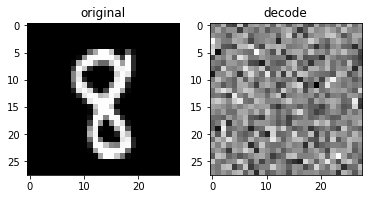

step :  5000 time :  26.468793153762817
total loss :  149.619
reg loss :  5.75362
rec loss :  143.866
latent variable :  [ 0.2517148  0.1019634]


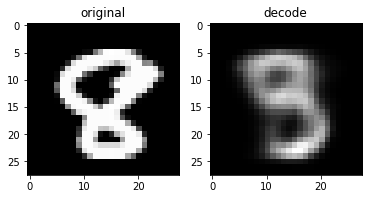

step :  10000 time :  26.134300470352173
total loss :  141.794
reg loss :  6.36108
rec loss :  135.433
latent variable :  [ 0.60123438  1.48939753]


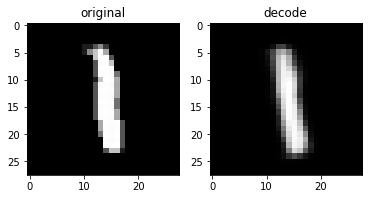

step :  15000 time :  25.305325508117676
total loss :  141.959
reg loss :  6.6291
rec loss :  135.33
latent variable :  [-0.50866234  0.77869838]


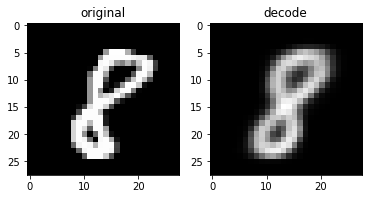

step :  20000 time :  25.479148387908936
total loss :  138.705
reg loss :  6.77981
rec loss :  131.925
latent variable :  [ 0.12656985 -0.7131874 ]


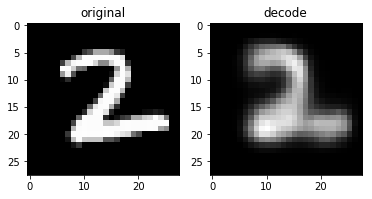

In [19]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
import time
t1 = time.time()
for i in range(epoch+1):
    
    # training
    batch_x,_ = MNIST.train.next_batch(bn)
    _,tloss,test_x,test_z,regl, recl =sess.run([train_step,total_loss,x_hat,z,reg_loss, rec_loss], feed_dict={x:batch_x})
    
    # show results
    if i %check_point==0:
        t2 = time.time()
        print('step : ',i, 'time : ', t2-t1)
        
        t1 = t2
        print('total loss : ', tloss)
        print('reg loss : ',np.mean(regl))
        print('rec loss : ',np.mean(recl))
        print('latent variable : ', test_z[0])    
        plt.subplot(1,2,1)
        plt.title('original')
        plt.imshow(batch_x[0].reshape(28,28), cmap='gray')
        plt.subplot(1,2,2)
        plt.title('decode')
        plt.imshow(test_x[0].reshape(28,28), cmap='gray')
        plt.show()
        
    

In [20]:
# latent space walking

z1 = np.linspace(-1,1,10)
z2 = np.linspace(-1,1,10)
test_z = np.zeros([100,2])
test_z = np.array(list(itertools.product(z1,z1)))
ind = 0
for i in z1:
    for j in z2:
        test_z[ind,:] = [i,j]
        ind += 1
        
temp = sess.run(x_hat, feed_dict={z: test_z })

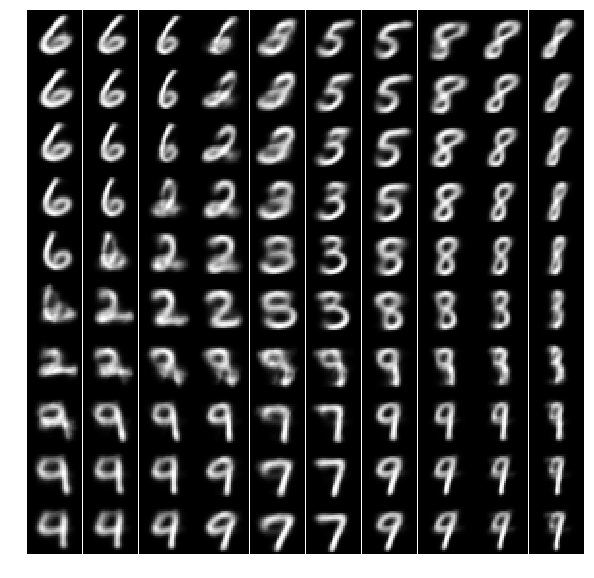

In [21]:
ind = 1
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,ind)
    plt.axis('off')
    plt.imshow(temp[i,:].reshape(28,28), cmap='gray')
    ind += 1
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()